In [1]:
import os
import re
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from string import punctuation
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, ReLU, GlobalMaxPooling1D, Conv1D, LeakyReLU, BatchNormalization, MaxPooling1D, Flatten

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Read JSON for first dataset
df_v1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df_v1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
# Read JSON for second dataset
df_v2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df_v2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
# Combine both datasets
df = pd.concat([df_v1, df_v2], ignore_index=True)
df = df.drop(columns=["article_link"])

df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
# Check for NaN values
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

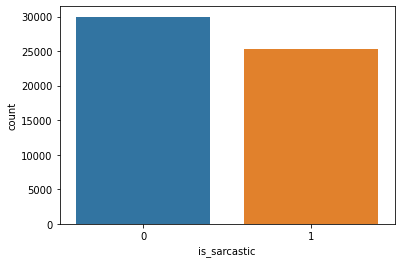

In [7]:
# Sarcastic vs. not sarcastic box plot
sns.countplot(x=df.is_sarcastic)

In [8]:
# Get stopwords (words that don't convey any meaning e.g: a, an, the)
stop = set(nltk.corpus.stopwords.words("english"))
punctuation = list(punctuation)
stop.update(punctuation)

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub("\[[^]]*\]", "", text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r"http\S+", "", text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [10]:
# Clean up headlines
df["headline"] = df["headline"].apply(denoise_text)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


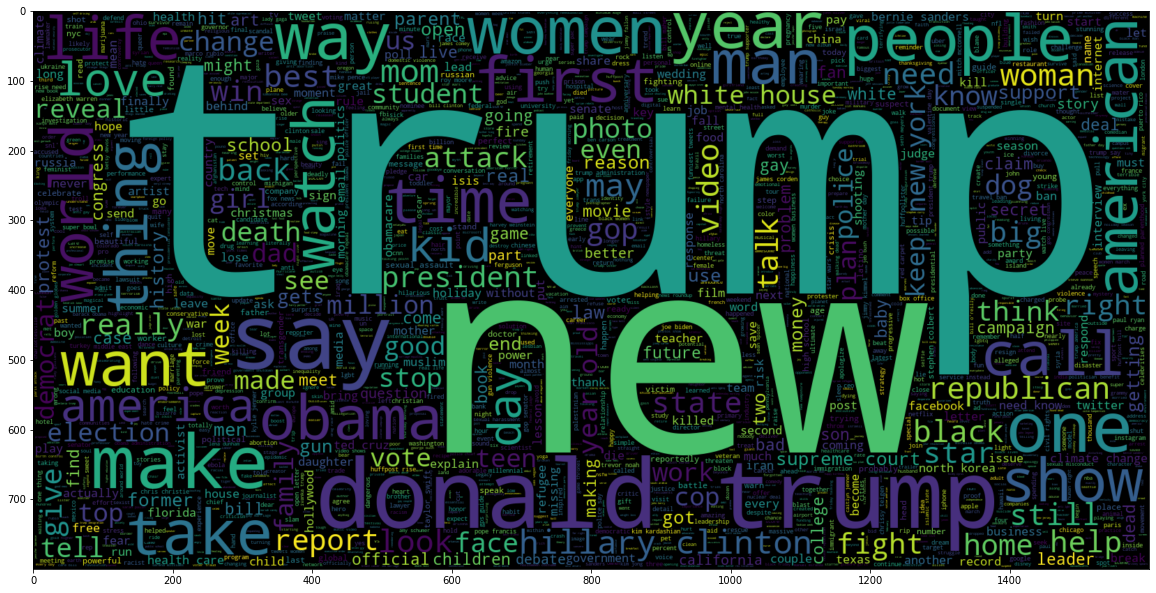

In [11]:
# Wordcloud of non-sarcastic text
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc, interpolation="bilinear")

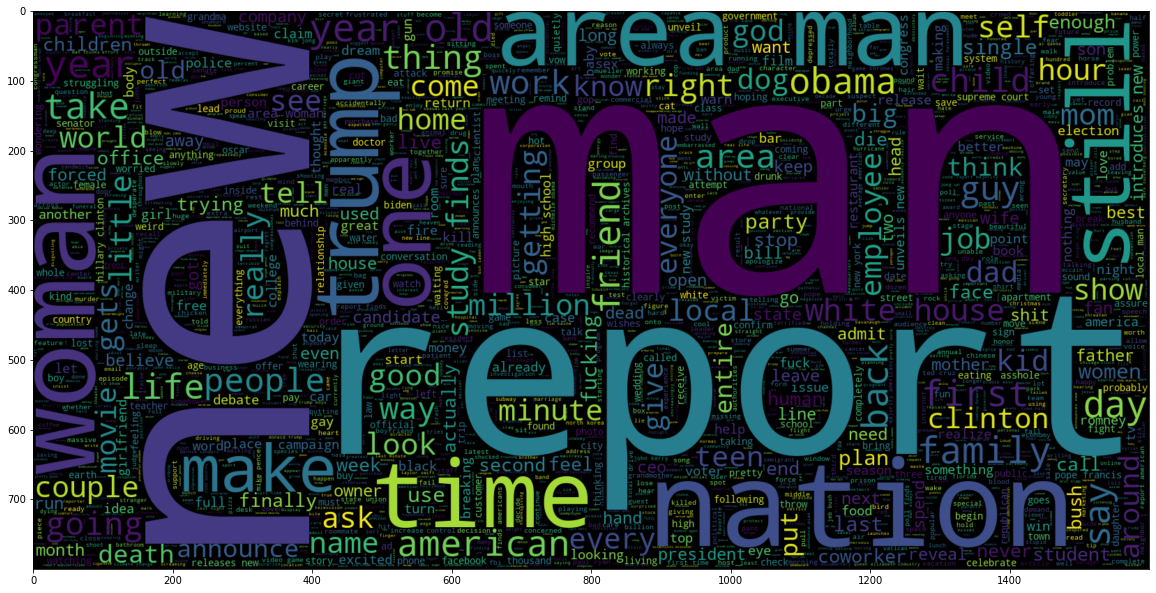

In [12]:
# Wordcloud of sarcastic text
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation="bilinear")

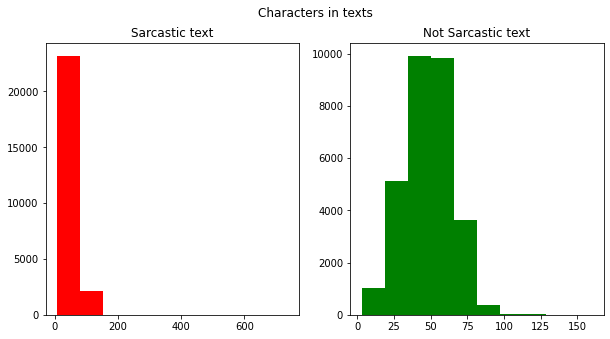

In [13]:
# Length of sarcastic text vs. non-sarcastic text (characters)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

text_len=df[df["is_sarcastic"] == 1]["headline"].str.len()
ax1.hist(text_len,color="red")
ax1.set_title("Sarcastic text")

text_len=df[df["is_sarcastic"] == 0]["headline"].str.len()
ax2.hist(text_len,color="green")
ax2.set_title("Not Sarcastic text")

fig.suptitle("Characters in texts")
plt.show()

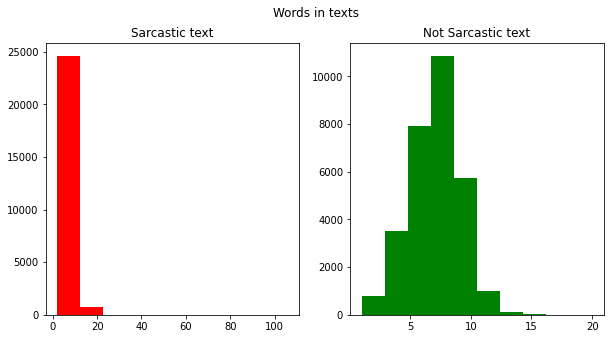

In [28]:
# Length of sarcastic text vs. non-sarcastic text (words)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df["is_sarcastic"] == 1]["headline"].str.split().map(lambda x: len(x))
ax1.hist(text_len,color="red")
ax1.set_title("Sarcastic text")

text_len=df[df["is_sarcastic"] == 0]["headline"].str.split().map(lambda x: len(x))
ax2.hist(text_len,color="green")
ax2.set_title("Not Sarcastic text")

fig.suptitle("Words in texts")
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

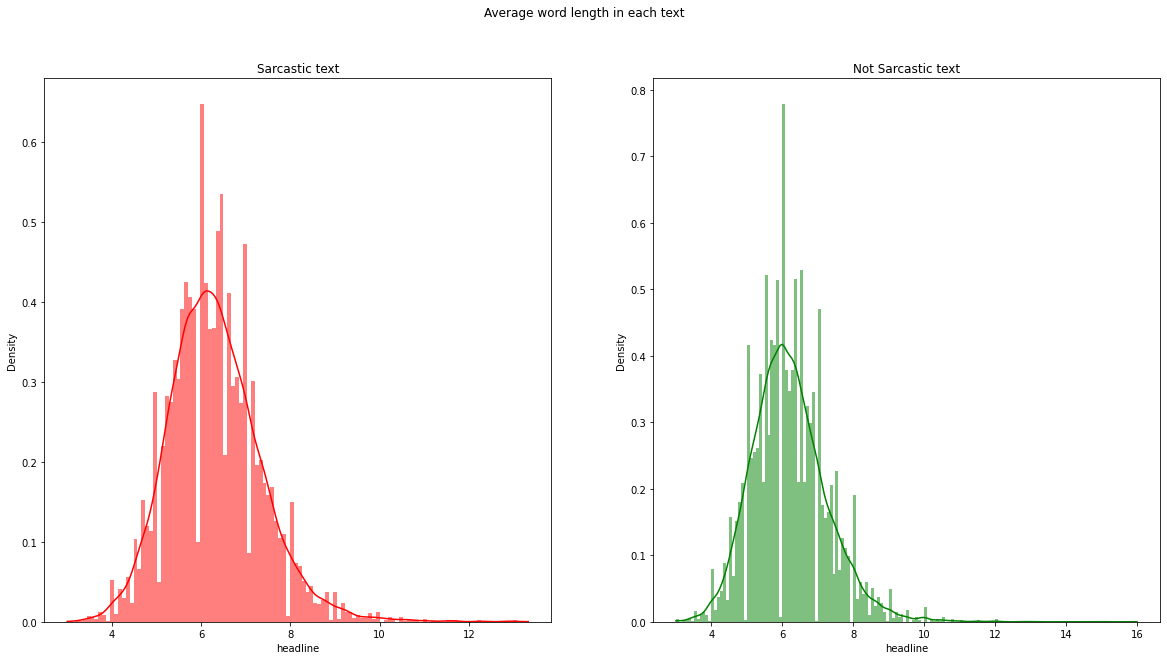

In [15]:
# Normal distribution of number of words
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = df[df["is_sarcastic"] == 1]["headline"].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax1, color="red", kde=True, stat="density", linewidth=0)
ax1.set_title("Sarcastic text")

word = df[df["is_sarcastic"] == 0]["headline"].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax2, color="green", kde=True, stat="density", linewidth=0)
ax2.set_title("Not Sarcastic text")

fig.suptitle("Average word length in each text")

In [16]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [17]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=words , size=EMBEDDING_DIM, window=5, min_count=1)

In [18]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

38071

In [19]:
tokenizer = Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
X = pad_sequences(tokenized_train, maxlen=20)

In [20]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [21]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [22]:
# Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, df.is_sarcastic, train_size=0.8, random_state=42) 

In [26]:
opt = Adam(learning_rate=0.0005)

model = Sequential()

model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(32)))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))

model.compile(
  optimizer=opt, 
  loss="binary_crossentropy", 
  metrics=["acc"]
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.15,
    shuffle=True
)

Epoch 1/10
294/294 [==============================] - 194s 587ms/step - loss: 0.6286 - acc: 0.6311 - val_loss: 0.3461 - val_acc: 0.8517
Epoch 2/10
294/294 [==============================] - 160s 542ms/step - loss: 0.2301 - acc: 0.9125 - val_loss: 0.2557 - val_acc: 0.9050
Epoch 3/10
294/294 [==============================] - 130s 443ms/step - loss: 0.0958 - acc: 0.9676 - val_loss: 0.2761 - val_acc: 0.9107
Epoch 4/10
294/294 [==============================] - 148s 504ms/step - loss: 0.0473 - acc: 0.9850 - val_loss: 0.3151 - val_acc: 0.9169
Epoch 5/10
294/294 [==============================] - 106s 359ms/step - loss: 0.0311 - acc: 0.9900 - val_loss: 0.3473 - val_acc: 0.9268
Epoch 6/10
294/294 [==============================] - 106s 360ms/step - loss: 0.0187 - acc: 0.9945 - val_loss: 0.3400 - val_acc: 0.9235
Epoch 7/10
294/294 [==============================] - 105s 358ms/step - loss: 0.0179 - acc: 0.9943 - val_loss: 0.3353 - val_acc: 0.9245
Epoch 8/10
294/294 [============================

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 256)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                73984     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64)               

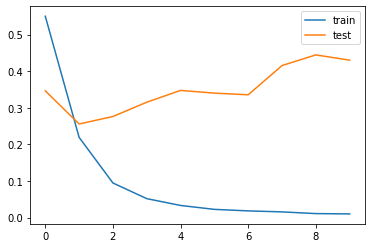

In [30]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend();

In [31]:
model.evaluate(X_test, y_test)

346/346 [==============================] - 9s 26ms/step - loss: 0.4001 - acc: 0.9295


[0.4000653922557831, 0.9295138120651245]

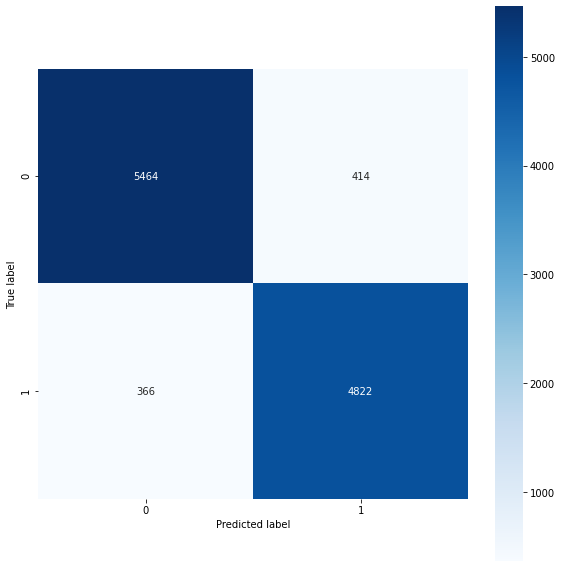

In [32]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, square=True, fmt="")
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test,y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))